In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix, accuracy_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
plt.style.use('seaborn-white')

### 1.loading the dataset

In [3]:
multiclass = pd.read_csv("../../dataset/multiclass_dataset_no_weird_obs.csv", header= 0)

In [6]:
data1, data2 =  train_test_split(multiclass, test_size=0.4, random_state=42,
                                              shuffle=True, stratify=None)
train1, test1  = train_test_split(data1, test_size=0.2, random_state=46,
                                              shuffle=True, stratify=None)
train2, test2  = train_test_split(data2, test_size=0.2, random_state=39,
                                              shuffle=True, stratify=None)
data1.to_csv("multi_1.csv")

In [7]:
y_test = test1.iloc[:,17395]
x_train = np.array(train1.drop(['label','Unnamed: 0','DepMap_ID'], axis = 1))
y_train = train1.iloc[:,17395]
x_test = np.array(test1.drop(['label','DepMap_ID','Unnamed: 0'], axis = 1))

In [8]:
y_train

114    4
219    6
571    7
595    4
845    0
      ..
964    7
546    8
676    2
875    0
38     3
Name: label, Length: 483, dtype: int64

### 2.Random Forest with the same parameters as in the RF.blood model

In [9]:
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 4, n_estimators = 504,
                    min_samples_split= 10, max_leaf_nodes= 35,
                    max_depth = 48, class_weight = "balanced",
                    bootstrap = True, oob_score = True)

In [10]:
rf.fit(x_train, y_train)
print('Training score: ', rf.score(x_train, y_train))
print('Test score: ', rf.score(x_test, y_test))

Training score:  1.0
Test score:  0.6363636363636364


In [11]:
y_pred = rf.predict(x_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

The accuracy of the model is 63.6 %


In [12]:
#Create the vectors that contains the Cancers chosen (Cancer_Type2) and the one observed (Cancer_Type)
Cancer_Type = ["Gastrointestinal","Genitals","Muscle-Bone","Neuro","Breast","Head_Neck","Blood",
               "Genitourinary", "Lung"] 

In [13]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test).set_axis(Cancer_Type, axis = 1)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

In [14]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 15,
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

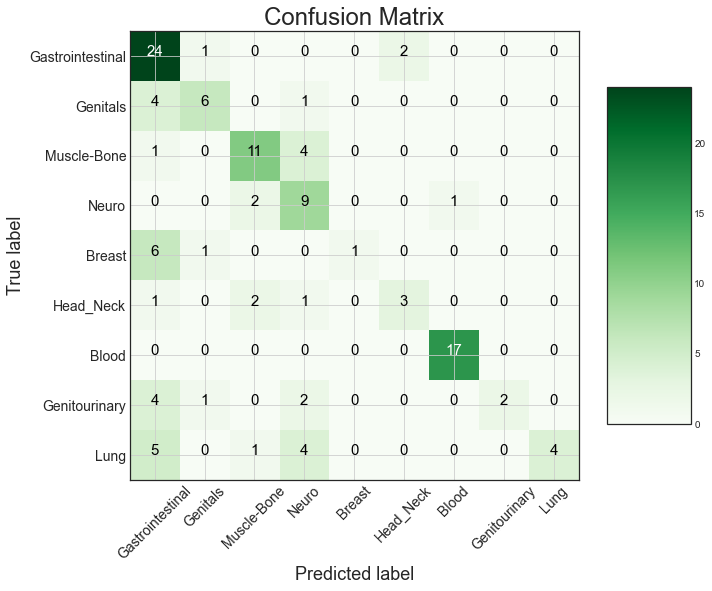

In [15]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### A model with different class weights

In [16]:
#let us compute the class frequencies loooking for some clues for balancing in a different way the classes
y_train_dummies = pd.get_dummies(y_train).set_axis(Cancer_Type, axis = 1)
y_train_dummies.sum()

Gastrointestinal    103
Genitals             46
Muscle-Bone          63
Neuro                69
Breast               18
Head_Neck            42
Blood                56
Genitourinary        28
Lung                 58
dtype: int64

In [81]:
rf_class_weighted = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 4, n_estimators = 504,
                    min_samples_split= 10, max_leaf_nodes= 35,
                    max_depth = 48, class_weight={0:1.05,1:3.1,2:1.9,3:1.65,4:11.5,5:2.3,6:2.5,7:5,8:2},
                    bootstrap = True, oob_score = True)

#class_weight={0:1.05,1:3.1,2:1.9,3:1.65,4:11.5,5:2.3,6:2.5,7:5,8:2}, Test score:  0.6776859504132231 almeno 1 in tutte le classi!
#class_weight={0:1.05,1:3.1,2:1.9,3:1.65,4:12.5,5:2.3,6:2.5,7:5,8:2}, Test score:  0.6694214876033058 almeno 1 in tutte le classi!

In [82]:
rf_class_weighted.fit(x_train, y_train)
print('Training score: ', rf_class_weighted.score(x_train, y_train))
print('Test score: ', rf_class_weighted.score(x_test, y_test))

Training score:  1.0
Test score:  0.6776859504132231


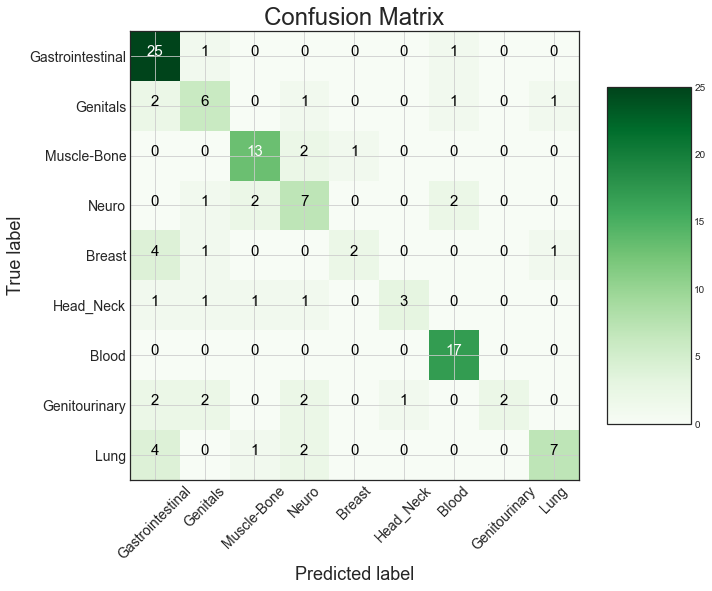

In [83]:
y_pred = rf_class_weighted.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### Selection of the important features

In [84]:
out = cross_validate(rf_class_weighted, x_train, y_train, cv = 5, n_jobs = -1,
                scoring = 'accuracy', return_estimator = True)

In [85]:
x_train_feature_impo = train1.drop(['label','Unnamed: 0','DepMap_ID'], axis = 1)

feat_impo_all = []
for i, estimator in enumerate(out['estimator']):
    print("First 10 features sorted by their importance for model n. {}:".format(i+1))
    feat_impo = pd.DataFrame(estimator.feature_importances_,
                            index = x_train_feature_impo.columns,
                            columns = ['Importance{}'.format(i+1)]).sort_values('Importance{}'.format(i+1), ascending = False)
    print(feat_impo[:10])
    print('--------------------------------')

    feat_impo_all.append(feat_impo[feat_impo['Importance{}'.format(i+1)] > 0.0001])
    
    
    
#altro metodo per feat_impo
# pd.DataFrame(out['estimator'][1].feature_importances_,
#                             index = x_train_feature_impo.columns,
#                             columns = ['Importance'.format(i+1)]).where(lambda x : x > 0.0005).dropna().index

First 10 features sorted by their importance for model n. 1:
                  Importance1
MYB..4602.           0.003340
PAX8..7849.          0.002661
MBNL1..4154.         0.002652
SPDEF..25803.        0.002609
ZEB2..9839.          0.002443
IKZF1..10320.        0.002216
TRPS1..7227.         0.002026
ATP1B3..483.         0.002006
ARHGAP45..23526.     0.001995
CBFB..865.           0.001945
--------------------------------
First 10 features sorted by their importance for model n. 2:
                  Importance2
ZEB2..9839.          0.003709
MYB..4602.           0.003458
PAX8..7849.          0.002655
CBFB..865.           0.002475
MBNL1..4154.         0.002358
FERMT2..10979.       0.002150
TRPS1..7227.         0.002064
NCKAP1..10787.       0.001951
SPDEF..25803.        0.001874
ARHGAP45..23526.     0.001833
--------------------------------
First 10 features sorted by their importance for model n. 3:
                Importance3
ZEB2..9839.        0.003711
MYB..4602.         0.002861
PAX8..7

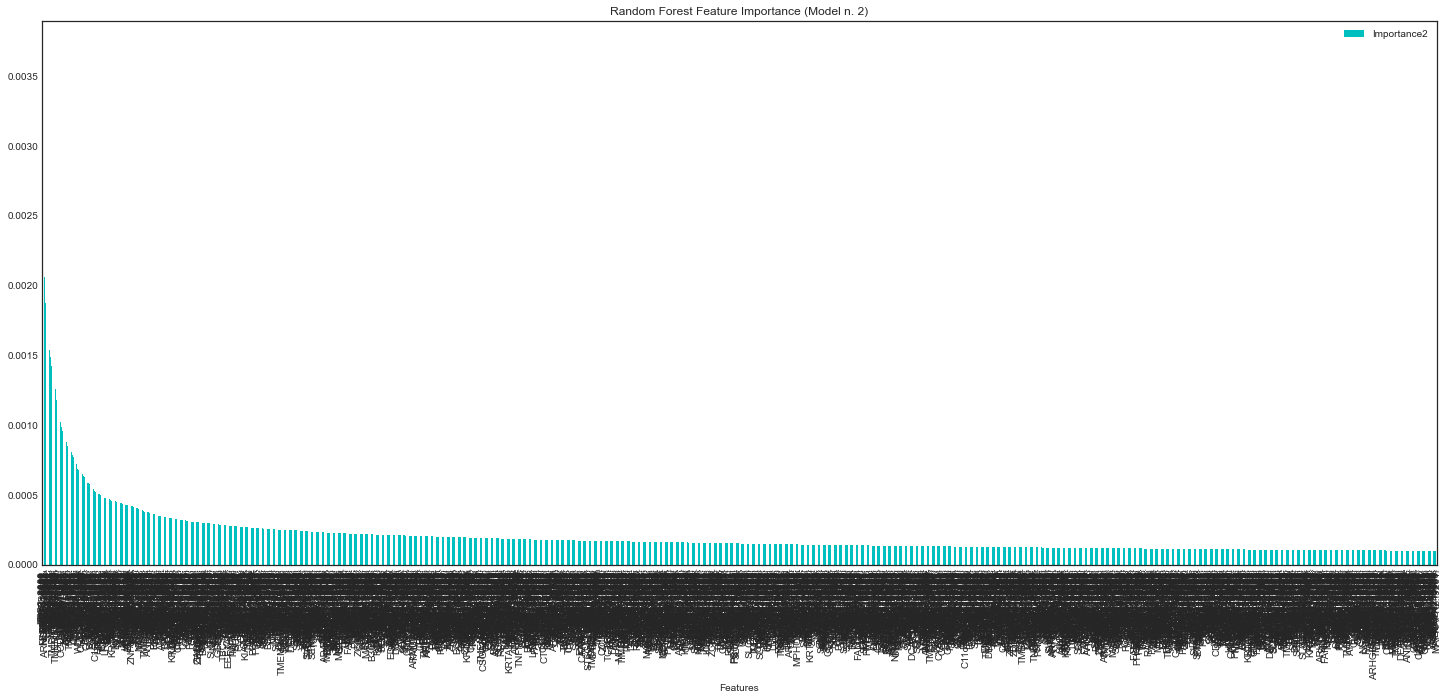

In [86]:
feat_impo_all[1].plot.bar(figsize = (25, 10), color = 'c')
plt.title('Random Forest Feature Importance (Model n. 2)')
plt.xlabel('Features')
plt.show()

### New model using the remaining features

In [88]:
df0 = pd.DataFrame(feat_impo_all[0])
df1 = pd.DataFrame(feat_impo_all[1])
df2 = pd.DataFrame(feat_impo_all[2])
df3 = pd.DataFrame(feat_impo_all[3])
df4 = pd.DataFrame(feat_impo_all[4])

#consider the features that show up in all the 5 list of the important features
most_impo_feat = pd.concat([df0, df1, df2, df3, df4], axis = 1).dropna()  #219 features
genes = most_impo_feat.index

In [89]:
# use data2 split that has been done at the beginning
y_test_2 = test2.iloc[:,17395]
x_train_2 = np.array(train2.filter(genes, axis = 1))
y_train_2 = train2.iloc[:,17395]
x_test_2 = np.array(test2.filter(genes,axis = 1))

In [90]:
#balanced RF
rf.fit(x_train_2, y_train_2)
print('Training score: ', rf.score(x_train_2, y_train_2))
print('Test score: ', rf.score(x_test_2, y_test_2))

Training score:  0.9968944099378882
Test score:  0.5308641975308642


In [91]:
#Same class weights as in the training
rf_class_weighted.fit(x_train_2, y_train_2)
print('Training score: ', rf_class_weighted.score(x_train_2, y_train_2))
print('Test score: ', rf_class_weighted.score(x_test_2, y_test_2))

Training score:  0.9937888198757764
Test score:  0.5061728395061729


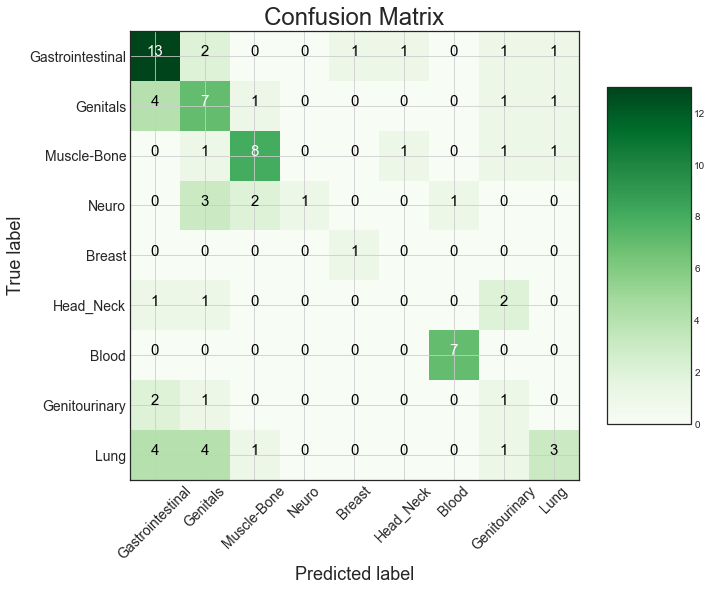

In [92]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test_2).set_axis(Cancer_Type, axis = 1)

y_pred = rf_class_weighted.predict(x_test_2)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

cm = confusion_matrix(y_test_2,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### Trying something strange

### Using the new set of features with NN

In [93]:
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [98]:
np.shape(x_train_2)

(322, 219)

In [100]:
X_train_reshaped = x_train_2.reshape(322,219)
X_test_reshaped = x_test_2.reshape(81,219)

y_train_NN = pd.get_dummies(y_train_2)
y_test_NN = pd.get_dummies(y_test_2)

In [101]:
def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [104]:
model = Sequential()

#1°layer
model.add(Dense(1500, input_shape=(219,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#2°layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#3°layer
model.add(Dense(9))
model.add(Activation('softmax'))

#categorical_crossentropy loss per classificazione (penalizza molto le previsioni che sono sbagliate ma con alta probabilità)
model.compile(optimizer = 'adam', metrics=['accuracy'], 
    loss=[categorical_focal_loss(alpha=[.25, .25, .25, .25, .25, .25, .25, .25, .25], gamma=2)])

early_stopping_monitor = EarlyStopping(patience= 30, monitor = 'val_accuracy')

model_chekpoint_callback = ModelCheckpoint(filepath='best_model_2.hdf5',
                                           monitor = 'val_accuracy',
                                           mode = 'auto',
                                           save_best_only=True,
                                           verbose=1)



hystory = model.fit(X_train_reshaped, y_train_NN,
         validation_data = (X_test_reshaped,y_test_NN),
                    epochs =100,
                   callbacks = (early_stopping_monitor,model_chekpoint_callback))


Epoch 1/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.3854 - accuracy: 0.2292
Epoch 00001: val_accuracy improved from -inf to 0.41975, saving model to best_model_2.hdf5
11/11 [==============================] - 1s 26ms/step - loss: 0.3817 - accuracy: 0.2453 - val_loss: 0.3105 - val_accuracy: 0.4198
Epoch 2/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.2773 - accuracy: 0.4965
Epoch 00002: val_accuracy improved from 0.41975 to 0.46914, saving model to best_model_2.hdf5
11/11 [==============================] - 0s 12ms/step - loss: 0.2761 - accuracy: 0.4969 - val_loss: 0.2684 - val_accuracy: 0.4691
Epoch 3/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.2243 - accuracy: 0.5278
Epoch 00003: val_accuracy improved from 0.46914 to 0.49383, saving model to best_model_2.hdf5
11/11 [==============================] - 0s 11ms/step - loss: 0.2243 - accuracy: 0.5311 - val_loss: 0.2307 - val_accuracy: 0.4938
Epoch 4/100
10/11 [==========================>

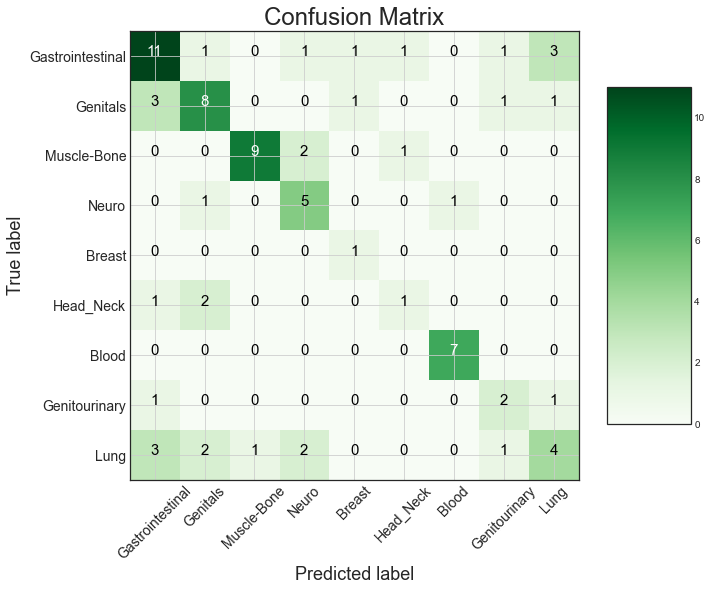

In [106]:
best_model_2 = load_model('best_model_2.hdf5', compile=False)
y_pred = np.argmax(best_model_2.predict(X_test_reshaped),axis = 1)
y_pred = pd.get_dummies(y_pred)
y_pred = y_pred.T.reindex(range(9)).T.fillna(0)


y_pred = np.argmax(best_model_2.predict(X_test_reshaped),axis = 1)
y_test_confusion = test2.iloc[:,17395]

cm = confusion_matrix(y_test_confusion,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

### Now let us analyze our model using the first 1700 feature found with Holden on R

In [113]:
multiclass = pd.read_csv("../../dataset/Holden.csv", header= 0)
holden = holden.iloc[0:1700]

In [114]:
test2_holden = test2.filter(holden['x_names'], axis = 1)
train2_holden = train2.filter(holden['x_names'], axis = 1)

In [119]:
X_test2 = np.array(test2_holden)
y_test2 = y_test_2 = test2.iloc[:,17395]
X_train2 = np.array(train2_holden)
y_train2 = train2.iloc[:,17395]

In [126]:
np.shape(y_train2)

(322,)

In [127]:
rf_class_weighted.fit(X_train2, y_train2)
print('Training score: ', rf_class_weighted.score(X_train2, y_train2))
print('Test score: ', rf_class_weighted.score(X_test2, y_test2))

Training score:  1.0
Test score:  0.41975308641975306


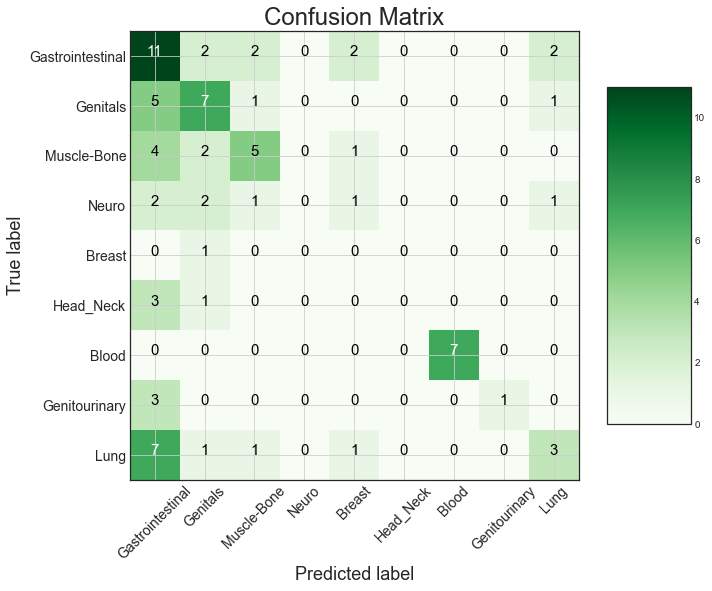

In [130]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test2).set_axis(Cancer_Type, axis = 1)

y_pred = rf_class_weighted.predict(X_test2)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

cm = confusion_matrix(y_test2,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')

###  Trying new class weights

In [144]:
#let us compute the class frequencies loooking for some clues for balancing in a different way the classes
y_train_dummies = pd.get_dummies(y_train2).set_axis(Cancer_Type, axis = 1)
y_train_dummies.sum()

Gastrointestinal    74
Genitals            36
Muscle-Bone         43
Neuro               34
Breast              18
Head_Neck           23
Blood               29
Genitourinary       24
Lung                41
dtype: int64

In [153]:
rf_class_weighted2 = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 4, n_estimators = 504,
                    min_samples_split= 10, max_leaf_nodes= 35,
                    max_depth = 48, class_weight={0:1,1:3,2:3,3:3,4:5,5:6.3,6:4.5,7:4,8:2},
                    bootstrap = True, oob_score = True)

In [154]:
rf_class_weighted2.fit(X_train2, y_train2)
print('Training score: ', rf_class_weighted2.score(X_train2, y_train2))
print('Test score: ', rf_class_weighted2.score(X_test2, y_test2))

Training score:  1.0
Test score:  0.35802469135802467


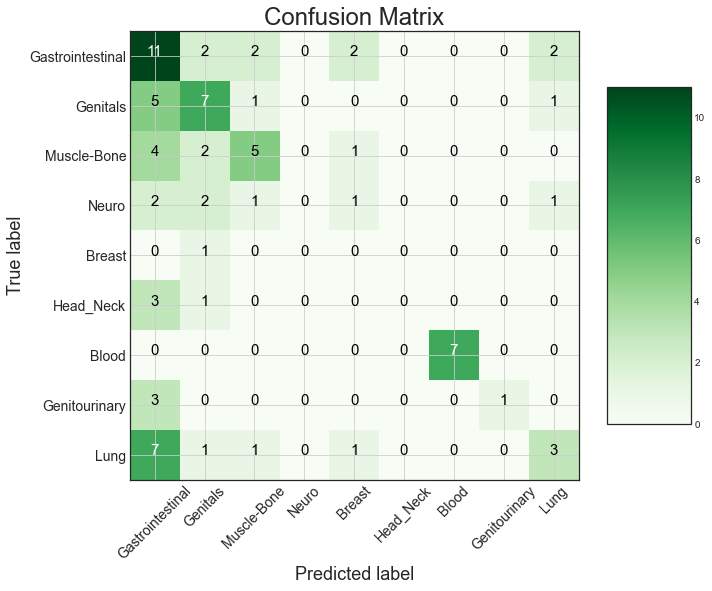

In [155]:
#Change the name of the coloumns of the class matrix created through get_dummies using more meaningful names
y_test_dummies = pd.get_dummies(y_test2).set_axis(Cancer_Type, axis = 1)

y_pred = rf_class_weighted.predict(X_test2)
y_pred_dummies = pd.get_dummies(y_pred, dummy_na= True).T.reindex(range(9)).T.fillna(0)
y_pred_dummies = y_pred_dummies.set_axis(Cancer_Type, axis= 1)

cm = confusion_matrix(y_test2,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')